[Kaggle Competition](https://www.kaggle.com/c/nfl-big-data-bowl-2021)

Purpose of this notebook is to generate prediction models for the coverage type, based on 2018 week 1 labels provided in the competition.

Reason behind building a coverage label prediction model is to label plays for all other weeks (2-17) and then use that as an additional feature of downstream analytics, either at the play-level or tracking data within plays of a specific coverage type.

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import nflutil

Loading the data:

In [4]:
week_num = 1

track_df = pd.read_csv(f'csv/week{week_num}.csv')
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df = pd.read_csv('csv/players.csv')
coverage_df = pd.read_csv('csv/coverages_week1.csv')

# Generate Features

Features are generated on a per-play basis to predict the overall defensive coverage scheme.

Unless specified as the value at a particular stage of the play (snap, throw, etc.), the features are calculated at each time step between the snap and a "pivot" event that will alter the behavior of the defense (i.e. throw or sack) or a maximum elapsed time after the snap, whichever is first. The maximum time is meant to limit the effect of the play breaking down on the planned movements of the players.

All defenders are evaluated at a threshold time in the play (e.g. 1.5 seconds after snap) if they are still beyond the line of scrimmage to determine which defenders are actually in coverage vs. blitzing. Blitzing player values would skew average results, and the movement of the rusher does not matter beyond the fact that they are not in coverage.

The following features are generated at a per-defender level (inspired by [this paper](https://arxiv.org/abs/1906.11373)), then averaged across all coverage defenders:

* **depth_mean**: average yards downfield of the defender (same as X_mean but normalizes for line of scrimmage)
* **depth_var**: variance in downfield movement (same as X_var, lower value expected for zone)
* **y_mean**: average horizontal location of defender
* **y_var**: variance in horizontal movement (lower value expected for zone)
* **speed_mean**: average speed of the defender, yd/sec (lower value expected for zone)
* **speed_var**: variance in speed of the defender (lower expected for zone)
* **off_mean**: average distance to the closest offensive player at each frame during a play (lower expected for man)
* **off_var**: variance in distance to the closest offensive player at each frame (lower expected for man)
* **def_mean**: average distance to the closest defender at each frame
* **def_var**: variance in distance to the closest defender at each frame
* **rat_mean**: see paper for better description
* **rat_var**: see paper for better description

New features: 

* **rat_o_los**: ratio of time during a play that a defender is facing the QB/line of scrimmage. Expected to be near 1 for zone (reading the QB's eyes, keeping receivers in front of them vs. turning and running with the receiver) **Current threshold is 60 degrees (240-300 deg) to account for man coverage following crossing routes or moving mostly sideways but slightly towards the LOS**

The following play-level features are generated:

* **n_cover**: the number of defenders with tracking data in coverage (beyond the LOS at t_defender_thresh sec)
* **n_cb**: the number of cornerbacks in the defensive formation
* **n_def_excess**: the number of coverage defenders minus eligible receivers (players available for zone or double coverage)

The following features are evaluated based on player locations at the snap (leverage info when defense do not disguise coverage pre-snap):
* **n_deep_snap**: the number of defenders over 10 yards downfield at the snap
* **cb_depth_snap_min**: depth of closest CB to the LOS (press vs. soft)
* **cb_depth_snap_mean**: average depth of CBs
* **cb_depth_snap_max**: depth of farther CB to the LOS (zone expected for far off the ball)

The following features are evaluated at the "freeze" time (determining which players are in coverage, coverage scheme is assumed to be materialized regardless if it was being disguised pre-snap or not):
* **n_deep_frz**: number of defenders over 10 yards downfield at "freeze"
* **def_spac_frz_avg**: spacing to nearest defender at "freeze", averaged over all coverage players
* **def_spac_frz_min**: same source as above, but minimum (larger expected for zone)
* **def_spac_frz_max**: same source as above, but maximum (smaller expected for zone)
* **cb_depth_frz_min**: same as at snap but at the "freeze" time
* **cb_depth_frz_mean**: same as at snap but at the "freeze" time
* **cb_depth_frz_max**: same as at snap but at the "freeze" time

In [24]:
def create_play_features(play_track_df, t_defender_thresh=1.5, t_scheme_develop=3, t_reaction_time=0):
    ### THE INPUT TRACKING DATA MUST BE NORMALIZED FOR DIRECTION BEFORE INPUT INTO THIS FUNCTION
    # inputs:
    #     - play_track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - t_defender_thresh: time in seconds after the snap to determine which players are in coverage
    #     - t_scheme_develop: time in seconds after the snap to set as a max time threshold
    #                         (i.e. before the play breaks down, after which the movement 
    #                          is not always indicative of the coverage scheme)
    #     - t_reaction_time: time in seconds after the ball thrown to continue taking statistics (paths
    #                        won't change until players realize the ball has been thrown)
    
    # local constants
    DEF_DEEP_THRESH = 10  # yards behind the line of scrimmage considered "deep" coverage

    # work on a copy of the data rather than the actual data (for temporary features)
    play_track_df = play_track_df.copy()
    
    # ------------- FEATURE GENERATION SETUP/INTERMEDIATE CALCULATIONS ----------------------
    
    # make a dictionary of nflId to position for each player in the play
    player_positions = play_track_df.groupby('nflId')[['nflId', 'position']].head(1).dropna()  # football is np.nan
    position_dict = dict(zip(player_positions['nflId'].tolist(), player_positions['position'].tolist()))
    
    # get play information
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]
    
    # save the distance downfield of all observations relative to the line of scrimmage
    play_track_df['depth'] = play_track_df['x'] - x_los
    
    # get frameId for specific points in the play (exclude handoff: not a material pivot part of the play,
    # also sometimes occurs prior to the snap)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']
    
    frame_max = play_track_df.frameId.max()
    frame_snap = play_track_df[play_track_df.event=='ball_snap']['frameId'].iloc[0]
    if np.any(play_track_df.event.isin(pivot_events)):
        frame_pivot = (play_track_df.frameId[play_track_df.event.isin(pivot_events)].iloc[0]
                       + int(round(10 * t_reaction_time)))
    else:
        frame_pivot = frame_max
    
    # important frameId's in the play:
    frame_start = frame_snap
    frame_cover_freeze = min(frame_max, frame_pivot, int(round(frame_snap + 10*t_defender_thresh)))
    frame_scheme_develop = int(frame_snap + round(10*t_scheme_develop))
    frame_end = min(frame_pivot, frame_scheme_develop, frame_max)
    
#     print(f'frame_start: {frame_start}')
#     print(f'frame_cover_freeze: {frame_cover_freeze}')
#     print(f'frame_scheme_develop: {frame_scheme_develop}')
#     print(f'frame_end: {frame_end}')
#     print(f'frame_max: {frame_max}')
    
    
    # filter out data from frames outside of the range (frame_start <= F <= frame_end)
    play_track_df = play_track_df[(play_track_df.frameId >= frame_start) & (play_track_df.frameId <= frame_end)]
    
    
    # ----- SAVE SLICES OF DATAFRAME FOR DEFENDERS AND COVERAGE AND ELIGIBLE RECEIVERS ----
    
    # get defensive player tracks that are in coverage (i.e. not blitzing/rushing the passer)
    def_positions = ['DE', 'DL', 'NT', 'LB', 'MLB', 'ILB', 'OLB', 'DB', 'CB', 'FS', 'SS', 'S']
    cover_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          play_track_df.position.isin(def_positions) & 
                          (play_track_df.depth > 0)]
    def_track = play_track_df[play_track_df.nflId.isin(cover_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # get offensive player tracks of eligible receivers (minus QB)
    off_positions = ['WR', 'RB', 'TE', 'FB', 'HB']
    off_track = play_track_df[play_track_df.position.isin(off_positions)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    
    # ------ PLAY CHARACTERISTICS AT SPECIFIC FRAMES/POINTS IN TIME -----------------------
    
    # find characteristics of scheme at the snap (line of scrimmage naturally divides offense + defense)
    n_deep_snap = np.sum((play_track_df.depth >= DEF_DEEP_THRESH) & (play_track_df.frameId == frame_start))
    n_cb = len(play_track_df[play_track_df.position=='CB'].groupby('nflId').head(1))
    cb_depth_at_snap = play_track_df.loc[(play_track_df.frameId == frame_start) & (play_track_df.position=='CB'), 'depth']
    
    # find characteristics of players in coverage at the "cover freeze time"
    n_deep_freeze = np.sum((play_track_df.nflId.isin(cover_players)) & 
                           (play_track_df.depth >= DEF_DEEP_THRESH) &
                           (play_track_df.frameId == frame_cover_freeze))
    cb_depth_at_freeze = play_track_df.loc[(play_track_df.frameId == frame_cover_freeze) & (play_track_df.position=='CB'), 'depth']
    
    # calculate the number of "excess defenders" (available for free zone or double coverage)
    # - negative either means uncovered, or potential receiver stays back in protection
    n_def_excess = len(cover_players) - len(play_track_df.nflId[play_track_df.position.isin(off_positions)].unique())
    
    
    # ------GENERATE FEATURES FOR EACH COVERAGE PLAYER AT EACH FRAME ---------------------
    
    feature_data = {'depth_mean': [],
                    'depth_var': [],
                    'y_mean': [],
                    'y_var': [],
                    'speed_mean': [],
                    'speed_var': [],
                    'off_mean': [],
                    'off_var': [],
                    'off_dir_mean': [],
                    'off_dir_var': [],
                    'def_mean': [],
                    'def_var': [],
                    'rat_mean': [],
                    'rat_var': [],
                    'rat_o_los': []
                   }
    
    # data that is not dependent on the specific player
    x_off = off_track['x'].to_numpy()  # (n_frame, n_off) array
    y_off = off_track['y'].to_numpy()  # (n_frame, n_off) array
    dir_off = off_track['dir'].to_numpy()  # (n_frame, n_off array)
    
    # preallocate numpy array for minimum distance to nearest defensive player for each frame
    dist_def_min_array = np.empty([len(play_track_df.frameId.unique()), len(cover_players)])
    dist_def_min_array[:] = np.nan
    
    # loop over each defensive player
    for i, player in enumerate(cover_players):
        x_player = def_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        depth_player = def_track['depth'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = def_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        s_player = def_track['s'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        o_player = def_track['o'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        dir_player = def_track['dir'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        
        x_def = def_track['x'].drop(columns=player).to_numpy()  # (n_frame, n_def-1) array
        y_def = def_track['y'].drop(columns=player).to_numpy()  # (n_frame, n_def-1) array
        
        # calculate distance to each player at each time
        dist_off = np.sqrt((x_player - x_off)**2 + (y_player - y_off)**2)  # (n_frame, n_off) array
        dist_off_min = np.nanmin(dist_off, axis=1) # (n_frame,) array
        dist_def = np.sqrt((x_player - x_def)**2 + (y_player - y_def)**2)  # (n_frame, n_off) array
        dist_def_min = np.nanmin(dist_def, axis=1) # (n_frame,) array
        
        # save minimum distances for each player in external array
        dist_def_min_array[:, i] = dist_def_min
        
        # get the direction of the closest offensive player at each time
        dir_off_min = dir_off[dist_off == dist_off_min.reshape(-1,1)]  # (n_frame,) array
        # calculate the difference between the defender direction and offense direction, accounting for 0-360 wrap
        dir_diff_m360 = dir_player - dir_off_min - 360  # min when defender dir = 359, offense dir = 0
        dir_diff = dir_player - dir_off_min             # min when wrap is not an issue (defender = 10, offense = 11)
        dir_diff_p360 = dir_player - dir_off_min + 360  # min when defender dir = 0, offense dir = 359
        temp_dir_compare = np.where(np.abs(dir_diff_m360) < np.abs(dir_diff), dir_diff_m360, dir_diff)
        dir_diff_min = np.where(np.abs(temp_dir_compare) < np.abs(dir_diff_p360), temp_dir_compare, dir_diff_p360)
        
        # calculate ratio of distance to closest offensive player "j" (d_i-j) and distance from same offensive player
        # to defensive player "k" nearest to current player (d_j-k)
        x_j = x_off[dist_off == dist_off_min.reshape(-1,1)]  # (n_frame,) array
        y_j = y_off[dist_off == dist_off_min.reshape(-1,1)]  # (n_frame,) array
        x_k = x_def[dist_def == dist_def_min.reshape(-1,1)]  # (n_frame,) array
        y_k = y_def[dist_def == dist_def_min.reshape(-1,1)]  # (n_frame,) array
        ratio = dist_off_min / np.sqrt((x_j - x_k)**2 + (y_j - y_k)**2)
        
        # calculate the ratio of frames a defender is facing the line of scrimmage
        rat_o_los = np.nanmean((o_player > 240) & (o_player < 300))
        
        # save average distance
        feature_data['depth_mean'].append(np.nanmean(depth_player))
        feature_data['depth_var'].append(np.nanvar(depth_player))
        feature_data['y_mean'].append(np.nanmean(y_player))
        feature_data['y_var'].append(np.nanvar(y_player))
        feature_data['speed_mean'].append(np.nanmean(s_player))
        feature_data['speed_var'].append(np.nanvar(s_player))
        feature_data['off_mean'].append(np.nanmean(dist_off_min))
        feature_data['off_var'].append(np.nanvar(dist_off_min))
        feature_data['off_dir_mean'].append(np.nanmean(dir_diff_min))
        feature_data['off_dir_var'].append(np.nanvar(dir_diff_min))
        feature_data['def_mean'].append(np.nanmean(dist_def_min))
        feature_data['def_var'].append(np.nanvar(dist_def_min))
        feature_data['rat_mean'].append(np.nanmean(ratio))
        feature_data['rat_var'].append(np.nanvar(ratio))
        feature_data['rat_o_los'].append(rat_o_los)
        
    # put results into a dataframe
    dist_df = pd.DataFrame(feature_data, index=cover_players)
    
    # return averages of all coverage players
    out_data = dist_df.mean()
    out_data['n_cover'] = len(cover_players)
    out_data['n_cb'] = n_cb
    out_data['n_deep_snap'] = n_deep_snap
    out_data['n_deep_frz'] = n_deep_freeze
    out_data['n_def_excess'] = n_def_excess
    out_data['def_spac_frz_avg'] = np.nanmean(dist_def_min_array[frame_cover_freeze - frame_start, :])
    out_data['def_spac_frz_min'] = np.nanmin(dist_def_min_array[frame_cover_freeze - frame_start, :])
    
    # add in CB-specific features
    if n_cb > 0:
        out_data['cb_depth_snap_min'] = np.nanmin(cb_depth_at_snap)
        out_data['cb_depth_snap_mean'] = np.nanmean(cb_depth_at_snap)
        out_data['cb_depth_snap_max'] = np.nanmax(cb_depth_at_snap)
        out_data['cb_depth_frz_min'] = np.nanmin(cb_depth_at_freeze)
        out_data['cb_depth_frz_mean'] = np.nanmean(cb_depth_at_freeze)
        out_data['cb_depth_frz_max'] = np.nanmax(cb_depth_at_freeze)
    else:
        out_data['cb_depth_snap_min'] = 0
        out_data['cb_depth_snap_mean'] = 0
        out_data['cb_depth_snap_max'] = 0
        out_data['cb_depth_frz_min'] = 0
        out_data['cb_depth_frz_mean'] = 0
        out_data['cb_depth_frz_max'] = 0
    
    return out_data
    
# # test the function
# game_id = 2018090600
# play_id = 190
# play_track_df = track_df[(track_df.gameId==game_id) & (track_df.playId == play_id)]
# test_df = nflutil.transform_tracking_data(play_track_df)
# out=create_play_features(test_df)
# out

In [33]:
def create_feature_dataframe(track_df, coverage_df, t_scheme_develop=4, t_reaction_time=0):
    # Transform the raw tracking data so that all offensive plays face the same direction,
    # group the tracking data for each play together
    test_df_group = nflutil.transform_tracking_data(track_df).groupby(['gameId', 'playId'])

    # ------ Create the features for each play ---------------------
    feature_df = pd.DataFrame()

    col_names = []
    values = []

    # loop over each play
    for (loop_game_id, loop_play_id), loop_track_df in test_df_group:

        # error block for easier debugging if a particular play runs into an error
        try:
            features = create_play_features(loop_track_df,
                                            t_scheme_develop=t_scheme_develop,
                                            t_reaction_time=t_reaction_time)
        except Exception as err:
            print(f'error in gameId {loop_game_id}, playId {loop_play_id}')
            raise err

        # first loop: save the output dataframe column names (gameId, playId, all feature names)
        if not col_names: # empty
            col_names.extend(['gameId', 'playId'])
            col_names.extend(features.index.tolist())

        # save the gameId, playId, and all feature values into a list
        loop_values = [loop_game_id, loop_play_id]
        loop_values.extend(features.values.tolist())
        values.append(loop_values)

    # convert the features into a dataframe (1 row per play), inner join on plays with labeled coverages
    feature_df = pd.DataFrame(values, columns=col_names)
    labeled_play_df = pd.merge(feature_df, coverage_df.dropna(), on=['gameId', 'playId'])

    # split coverage into "Cover X" and Zone labels

    # Zone
    labeled_play_df['zone'] = 0
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Zone'), 'zone'] = 1

    # Cover X (Prevent will be listed as np.nan)
    labeled_play_df['cover'] = np.nan
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'cover'] = (
        labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'coverage'].apply(
        lambda x: int(x.split()[1]))
    )
    
    # return the feature dataframe
    return labeled_play_df

# ---------------- call function
labeled_play_df = create_feature_dataframe(track_df, coverage_df)

Labeled coverage counts:

In [7]:
labeled_play_df.coverage.value_counts()

Cover 3 Zone    352
Cover 1 Man     296
Cover 4 Zone    152
Cover 2 Zone    113
Cover 6 Zone     69
Cover 2 Man      32
Cover 0 Man      13
Prevent Zone      1
Name: coverage, dtype: int64

For labeled coverages, prevent won't be trained. It will be easy to spot with large average depth of the defenders at the snap.

# Classification of All Coverage Types (Multi-class, abbr = "_ac")

## Train-test split

Coverage label is encoded into integer labels

In [9]:
# drop the prevent defense example from training (will handle that case outside of algorithm)
ac_df = labeled_play_df.copy()
ac_df = ac_df[ac_df.coverage != 'Prevent Zone']

# train test split
y_ac_encoder = OrdinalEncoder().fit(ac_df.coverage.to_numpy().reshape(-1,1))
y_ac = y_ac_encoder.transform(ac_df.coverage.to_numpy().reshape(-1,1)).ravel()
X_ac = ac_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
X_ac_train, X_ac_test, y_ac_train, y_ac_test = train_test_split(X_ac, y_ac, 
                                                                test_size=0.2, stratify=y_ac, random_state=123456)

Confirm no leakage variables in feature set (gameId, playId, labels, etc.)

In [10]:
X_ac.columns

Index(['depth_mean', 'depth_var', 'y_mean', 'y_var', 'speed_mean', 'speed_var',
       'off_mean', 'off_var', 'off_dir_mean', 'off_dir_var', 'def_mean',
       'def_var', 'rat_mean', 'rat_var', 'rat_o_los', 'n_cover', 'n_cb',
       'n_deep_snap', 'n_deep_frz', 'n_def_excess', 'def_spac_frz_avg',
       'def_spac_frz_min', 'cb_depth_snap_min', 'cb_depth_snap_mean',
       'cb_depth_snap_max', 'cb_depth_frz_min', 'cb_depth_frz_mean',
       'cb_depth_frz_max'],
      dtype='object')

In [11]:
y_ac_encoder.categories_

[array(['Cover 0 Man', 'Cover 1 Man', 'Cover 2 Man', 'Cover 2 Zone',
        'Cover 3 Zone', 'Cover 4 Zone', 'Cover 6 Zone'], dtype=object)]

## Train model

StandardScaler isn't necessary for random forest, but included in case the pipeline is modified later to include another algorithm that does need feature scaling

In [12]:
# build pipeline
estimators_ac = [('normalize', StandardScaler()),
              ('clf', RandomForestClassifier(n_estimators=100, random_state=123456))]
pipe_ac = Pipeline(estimators_ac)

# build grid search
param_grid_ac = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 2, 4, 8],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__min_samples_leaf': [5, 10]  # min > 1 to help control overfitting
}

clf_ac = GridSearchCV(pipe_ac, param_grid=param_grid_ac)
clf_ac.fit(X_ac_train, y_ac_train)
print(f'Train accuracy: {accuracy_score(y_ac_train, clf_ac.predict(X_ac_train)):.3f}')
print(f'CV average accuracy: {clf_ac.best_score_:.3f}')

Train accuracy: 0.853
CV average accuracy: 0.604


In [13]:
clf_ac.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 5}

In [14]:
y_ac_pred = clf_ac.predict(X_ac_test)
print(f'Test accuracy: {accuracy_score(y_ac_test, y_ac_pred):.3f}')
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_ac_test, y_ac_pred),
                   index=('(A) ' + y_ac_encoder.categories_[0]),
                   columns=('(P) ' + y_ac_encoder.categories_[0]))

Test accuracy: 0.549
Confusion Matrix: 


,(P) Cover 0 Man,(P) Cover 1 Man,(P) Cover 2 Man,(P) Cover 2 Zone,(P) Cover 3 Zone,(P) Cover 4 Zone,(P) Cover 6 Zone
(A) Cover 0 Man,0,1,0,0,1,1,0
(A) Cover 1 Man,0,37,0,3,19,0,0
(A) Cover 2 Man,0,3,0,3,0,0,0
(A) Cover 2 Zone,0,3,0,10,6,4,0
(A) Cover 3 Zone,0,12,0,2,56,1,0
(A) Cover 4 Zone,0,6,0,4,10,10,0
(A) Cover 6 Zone,0,1,0,2,8,3,0


In [15]:
pd.Series(clf_ac.best_estimator_['clf'].feature_importances_, index=X_ac.columns).sort_values(ascending=False)

n_deep_frz            0.089372
depth_mean            0.074819
cb_depth_snap_min     0.066593
cb_depth_frz_max      0.062645
cb_depth_frz_mean     0.054000
off_mean              0.053256
n_deep_snap           0.049379
speed_var             0.042502
cb_depth_frz_min      0.036005
def_spac_frz_min      0.033978
def_spac_frz_avg      0.032988
cb_depth_snap_max     0.032573
cb_depth_snap_mean    0.032443
def_mean              0.031342
off_dir_var           0.029778
rat_mean              0.029770
speed_mean            0.027574
def_var               0.026961
off_var               0.026206
depth_var             0.024261
rat_var               0.023554
rat_o_los             0.022582
off_dir_mean          0.020501
y_mean                0.020008
y_var                 0.019924
n_cover               0.017021
n_def_excess          0.014789
n_cb                  0.005178
dtype: float64

# Classification of Zone vs. Man (Binary)

## Train-test split

In [34]:
# use whole set of data
zone_df = labeled_play_df.copy()

# train test split
y_z = zone_df.zone
X_z = zone_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
X_z_train, X_z_test, y_z_train, y_z_test = train_test_split(X_z, y_z, test_size=0.2, stratify=y_z, random_state=123456)

## Train model

StandardScaler isn't necessary for random forest, but included in case the pipeline is modified later to include another algorithm that does need feature scaling

In [44]:
# build pipeline
estimators_z = [('normalize', StandardScaler()),
              ('clf', RandomForestClassifier(n_estimators=200, random_state=123456))]
pipe_z = Pipeline(estimators_z)

# build grid search
param_grid_z = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 2, 4, 8],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__min_samples_leaf': [1]
}

clf_z = GridSearchCV(pipe_z, param_grid=param_grid_z)
clf_z.fit(X_z_train, y_z_train)
print(f'Train accuracy: {accuracy_score(y_z_train, clf_z.predict(X_z_train)):.3f}')
print(f'CV average accuracy: {clf_z.best_score_:.3f}')

Train accuracy: 0.982
CV average accuracy: 0.819


In [45]:
clf_z.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 8,
 'clf__max_features': 'log2',
 'clf__min_samples_leaf': 1}

In [46]:
y_z_pred = clf_z.predict(X_z_test)
print(f'Test accuracy: {accuracy_score(y_z_test, y_z_pred):.3f}')
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_z_test, y_z_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone'])

Test accuracy: 0.840
Confusion Matrix: 


,Pred. Man,Pred. Zone
Actual Man,42,26
Actual Zone,7,131


In [47]:
pd.Series(clf_z.best_estimator_['clf'].feature_importances_, index=X_z.columns).sort_values(ascending=False)

depth_mean            0.103601
cb_depth_snap_min     0.099052
off_mean              0.064130
speed_var             0.051491
cb_depth_snap_mean    0.045217
cb_depth_frz_mean     0.044597
cb_depth_frz_min      0.043218
cb_depth_frz_max      0.038045
rat_var               0.037377
n_deep_frz            0.036562
rat_mean              0.033849
def_spac_frz_min      0.032409
off_var               0.031242
cb_depth_snap_max     0.029984
def_var               0.028388
rat_o_los             0.028054
n_cover               0.027211
y_var                 0.026851
depth_var             0.025651
speed_mean            0.025055
off_dir_mean          0.023122
def_mean              0.023022
y_mean                0.020492
n_def_excess          0.020151
off_dir_var           0.020063
def_spac_frz_avg      0.019944
n_deep_snap           0.012653
n_cb                  0.008569
dtype: float64

# Check Random Forest Asymptote

In [42]:
spacing = 10
n_trees = np.arange(spacing, 200+spacing, spacing)
rf_accuracy = []

for n_tree in n_trees:
    rf_estimator = RandomForestClassifier(n_estimators=n_tree, min_samples_leaf=1, random_state=123456)
    estimators_loop = Pipeline([('normalize', StandardScaler()),
                                ('clf', rf_estimator)])
    estimators_loop.fit(X_z_train, y_z_train)
    rf_accuracy.append(accuracy_score(y_z_test, estimators_loop.predict(X_z_test)))

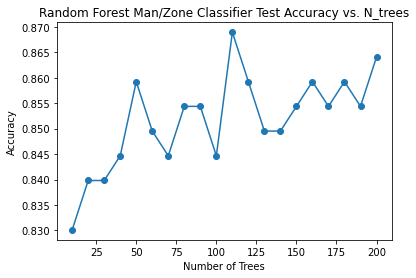

In [43]:
# plot results
plt.figure()
plt.plot(n_trees, rf_accuracy, 'o-')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Man/Zone Classifier Test Accuracy vs. N_trees');

Increasing the number of trees does have a slight positive effect on the accuracy.

# Check other classification schemes

In [39]:
# build pipeline
estimators_cl = [('normalize', StandardScaler()),
              ('clf', SVC())]
pipe_cl = Pipeline(estimators_cl)

# build grid search
param_grid_cl = [
    {
        'clf': [SVC(random_state=123456)],
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
    },
    {
        'clf': [KNeighborsClassifier()],
        'clf__n_neighbors': [3, 5, 7, 10, 15]
    },
    {
        'clf': [GaussianNB()]
    },
    {
        'clf': [AdaBoostClassifier(random_state=123456)],
        'clf__n_estimators': [20, 50, 100, 200]
    }
]

clf_cl = GridSearchCV(pipe_cl, param_grid=param_grid_cl)
clf_cl.fit(X_z_train, y_z_train)
print(f'Train accuracy: {accuracy_score(y_z_train, clf_cl.predict(X_z_train)):.3f}')
print(f'CV average accuracy: {clf_cl.best_score_:.3f}')

Train accuracy: 0.893
CV average accuracy: 0.832


In [40]:
clf_cl.best_params_

{'clf': SVC(random_state=123456), 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

In [41]:
y_z_pred = clf_cl.predict(X_z_test)
print(f'Test accuracy: {accuracy_score(y_z_test, y_z_pred):.3f}')
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_z_test, y_z_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone'])

Test accuracy: 0.850
Confusion Matrix: 


,Pred. Man,Pred. Zone
Actual Man,47,21
Actual Zone,10,128


The best of the other schemes tend to have around the same accuracy of the random forest classifier.

# Test other cutoff times for the parameters

## t_scheme_develop

In [58]:
t_scheme_develop = np.arange(2.0, 4.01, 0.1)
acc = []

for t in t_scheme_develop:
    # create feature dataframe
    feature_df = create_feature_dataframe(track_df, coverage_df, t_scheme_develop=t)
    
    # create train-test split
    y = feature_df.zone
    X = feature_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)
    
    # train model
    estimators = [('normalize', StandardScaler()),
              ('clf', RandomForestClassifier(n_estimators=100, random_state=123456))]
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    # get test set accuracy
    acc.append(accuracy_score(y_test, pipe.predict(X_test)))

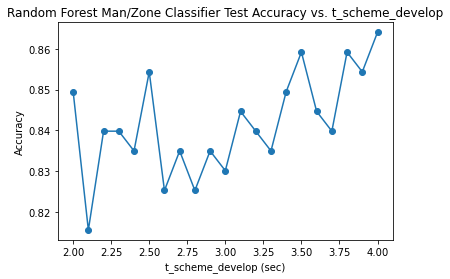

In [60]:
# plot
plt.figure()
plt.plot(t_scheme_develop, acc, 'o-')
plt.xlabel('t_scheme_develop (sec)')
plt.ylabel('Accuracy')
plt.title('Random Forest Man/Zone Classifier Test Accuracy vs. t_scheme_develop');

The accuracy seems to get better as the develop time gets higher. Makes sense since it is more data.

## t_reaction_time

In [29]:
t_scheme_develop = 4
t_reaction_time = np.arange(0.0, 1.01, 0.1)
acc = []

for t in t_reaction_time:
    # create feature dataframe
    feature_df = create_feature_dataframe(track_df, coverage_df, t_scheme_develop=t_scheme_develop, t_reaction_time=t)
    
    # create train-test split
    y = feature_df.zone
    X = feature_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)
    
    # train model
    estimators = [('normalize', StandardScaler()),
              ('clf', RandomForestClassifier(n_estimators=100, random_state=123456))]
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    # get test set accuracy
    acc.append(accuracy_score(y_test, pipe.predict(X_test)))

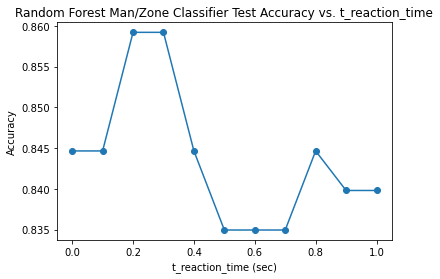

In [30]:
# plot
plt.figure()
plt.plot(t_reaction_time, acc, 'o-')
plt.xlabel('t_reaction_time (sec)')
plt.ylabel('Accuracy')
plt.title('Random Forest Man/Zone Classifier Test Accuracy vs. t_reaction_time');

No apparent impact on reaction time vs. accuracy. Maybe small value should be used (e.g. 0.2 seconds).

## t_scheme_develop > 4

In [31]:
t_scheme_develop = np.arange(4, 6.01, 0.5)
acc = []

for t in t_scheme_develop:
    # create feature dataframe
    feature_df = create_feature_dataframe(track_df, coverage_df, t_scheme_develop=t)
    
    # create train-test split
    y = feature_df.zone
    X = feature_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)
    
    # train model
    estimators = [('normalize', StandardScaler()),
              ('clf', RandomForestClassifier(n_estimators=100, random_state=123456))]
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    # get test set accuracy
    acc.append(accuracy_score(y_test, pipe.predict(X_test)))

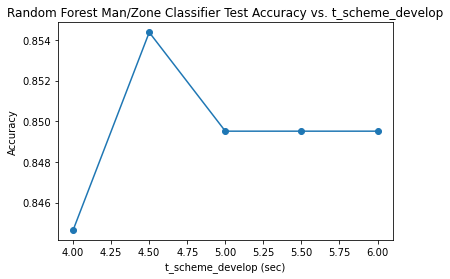

In [32]:
# plot
plt.figure()
plt.plot(t_scheme_develop, acc, 'o-')
plt.xlabel('t_scheme_develop (sec)')
plt.ylabel('Accuracy')
plt.title('Random Forest Man/Zone Classifier Test Accuracy vs. t_scheme_develop');

# NEXT UP

**To-Do:**

* Investigate data to create new features to better predict man coverage

**Completed:**

* Look at higher t_scheme_develop values > 4 sec
    * No meaningful impact > 4 sec
* Change the rat_o_los calculator to use a much lower angle as facing the line of scrimmage (e.g. 60 deg cone: 240-300 deg instead of 180-360 deg)
    * Larger range of values but does not seem to materially impact accuracy
* Allow a buffer time after the "throw" event to account for reaction time (i.e. players continuing to do their assignment until they realize the ball has been thrown). Since the accuracy tends to go up as t_scheme_develop goes up, longer periods of data seem to give better predictive results.
    * Does not appear to impact the results